In [1]:
import pandas as pd
import numpy as np

_m = pd.read_pickle('moonshot_submissions.p')



moonshot = _m.loc[_m.okay][['CID (canonical)','CID_group', 'old_index', 'clean_creator', 'SMILES', 'new_smiles',
                           'fragments', 'xcode', 'Structure ID', 'xcode','site_name', 'pdb_entry',
                            'series',
                            'ORDERED', 'MADE', 'ASSAYED', 'in_fragalysis',
                            'IC50', 'pIC50',
                           'submission_date', 'inferred_submission_date', 'order_date', 'shipment_date', 
                           'description', 'initial_screen',
                           'N_creator_submission', 'N_submission_group', 'resubmitted',
                           'Enamine - REAL Space', 'Enamine - Extended REAL Space',
                           'Enamine - SCR', 'Enamine - BB', 'Mcule', 'Mcule Ultimate',
                           'N_chars', 'N_words', 'N_words_cutoff', 'classified_method', 'flesch',
                           'dale_chall']]

#del _m

In [2]:
moonshot['purchasable'] = moonshot[['Enamine - REAL Space', 'Enamine - Extended REAL Space',
               'Enamine - SCR', 'Enamine - BB', 'Mcule', 'Mcule Ultimate']].apply(lambda row: ((row.astype(str) != 'False') & (row.astype(str) != '') & (row.astype(str) != 'nan')).any(), axis=1)

In [3]:
from rdkit import Chem
from rdkit.Contrib.SA_Score import sascorer
sascorer.readFragmentScores()

moonshot['SAScore'] = moonshot.SMILES.apply(Chem.MolFromSmiles).apply(sascorer.calculateScore).fillna(10)

[14:38:24] WARNING: not removing hydrogen atom without neighbors
[14:38:24] WARNING: not removing hydrogen atom without neighbors


In [4]:
cabal = ['Aaron Morris',
 'Alessandro Contini',
 'Alpha Lee',
 'Andre Schützer de Godoy',
 'Andrea Rizzi',
 'Anna Carbery',
 'Annette von Delft',
 'Anthony Aimon',
 'Austin Clyde',
 'Daren Fearon',
 'Demetri Moustakas',
 'Ed Griffen',
 'Edward Griffen',
 'Frank von Delft',
 'Garrett M. Morris',
 'Garrett Morris',
 'Halina Mikolajek',
 'Hannah Bruce Macdonald',
 'Hannah Bruce-Macdonald',
 'Jason Cole',
 'Jason Pattis',
 'Jenke Scheen',
 'Jin Pan',
 'John Chodera',
 'Kadi Liis Saar',
 'Lizbé Koekemoer',
 'Mark Calmiano',
 'Mark Williamson',
 'Matt Hurley',
 'Matt Robinson',
 'Matt Wittmann',
 'Matteo Ferla',
 'Matthew Hurley',
 'Matthew Robinson',
 'Matthew Wittmann',
 'Med-Chem team',
 'Melissa Boby',
 'Michael Retchin',
 'Mihaela Smilova',
 'Milan Cvitkovic',
 'Nir London',
 'Rajath Salegame',
 'Richard Foster',
 'Robert Glen',
 'Ruby Pai',
 'Tim Dudgeon',
 'Tyler Gorrie-Stone',
 'Vincent Voelz',
 'Warren Thompson',
 'Will Glass',
 'William Glass',
 'William McCorkindale',
 'Yuanqing Wang']

moonshot['internal'] = moonshot.clean_creator.str.lower().isin(list(map(str.lower, cabal)))
moonshot['midprefix'] = moonshot['CID (canonical)'].str.extract(r'\w{3}-(?P<mid_prefix>\w{3})').mid_prefix


In [5]:
moonshot['category'] = moonshot.internal.map({True: 'Core', False: 'Community'})
moonshot['quarter (shipment)'] = moonshot.shipment_date.apply(lambda d: 1+int(d.month // 3 + 4 * (d.year -2020)) if str(d.month) != 'nan' else -1)

In [6]:
moonshot['quarter (submission)'] = moonshot.inferred_submission_date.apply(lambda d: 1+int(d.month // 3 + 4 * (d.year -2020)) if str(d.month) != 'nan' else -1)

In [ ]:
import plotly.express as px
from datetime import datetime

fig = px.histogram(moonshot.loc[moonshot.inferred_submission_date < datetime(day=1, month=6, year=2020)],
                   x='SAScore', color='category',
                   title='Synthetic accessibility of compounds submitted in Spring 2020',
                  )
fig.write_image("SAScore_corevcomm_histo.jpg")
fig.show()

In [ ]:
import plotly.express as px
from datetime import datetime

fig = px.violin(moonshot,
          template="plotly_white",
                   y='SAScore', x='quarter (submission)', color='category',
                   title='Synthetic accessibility of compounds', box=True,
                #points='all',
                  )
fig.update_layout(xaxis=dict(range=[1.5,7.5]))
fig.update_traces(spanmode = 'hard')
fig.write_image("SAScore_corevcomm_vio.jpg")
fig.show()

In [ ]:
fixed_date = moonshot.inferred_submission_date.apply(lambda v: v if isinstance(v, pd.Timestamp) else np.nan)

In [ ]:
from datetime import datetime

fig = px.histogram(moonshot.loc[fixed_date < datetime(day=1, month=6, year=2020)],
                   color='purchasable', x='category',
                   title='Catalogue availability of compounds submitted in Spring 2020',
                  )
fig.write_image("catalogue_corevcomm.jpg")
fig.show()

## NB catalogue stops being added after a while

In [ ]:
from datetime import datetime

fig = px.histogram(moonshot,
                   color='purchasable', x='quarter (submission)',
                   title='Catalogue availability of compounds submitted in Spring 2020',
                  )
#fig.write_image("catalogue_corevcomm.jpg")
fig.show()

## % purchasable

In [ ]:
(pd.pivot_table(moonshot.loc[moonshot['quarter (submission)'] < 3], 
               index='category',
               values='purchasable', 
               aggfunc=sum) / \
pd.pivot_table(moonshot.loc[moonshot['quarter (submission)'] < 3], 
               index='category',
               values='purchasable', 
               aggfunc=len) * 100).round(1).rename(columns={'purchasable': '% purchasable'}).transpose()

In [ ]:
baddies = moonshot.sort_values('SAScore', ascending=False).head(20)
baddies['mol'] = baddies.SMILES.apply(Chem.MolFromSmiles)

from rdkit.Chem import Draw

d = baddies.SAScore.round(1).astype(str) + '\n' + baddies.description.str.slice(0,50)
Draw.MolsToGridImage(baddies['mol'], legends=d.to_list())

In [ ]:
midfices = moonshot.midprefix.value_counts().to_dict()
common_midfices = [m for m, v in midfices.items() if v > 50]

In [ ]:
fig = px.violin(moonshot.loc[moonshot.midprefix.isin(common_midfices)].sort_values('midprefix'), 
                x='midprefix', y='SAScore',
               title='Distribution of SAScore per group (w/ > 50 submissions)'
               )
fig.update_layout(violingap=0)
fig

In [ ]:
## Postera SAScore


In [60]:
import os, requests, json
from typing import Union, List, Tuple, Dict, Any

class SinglePostera:
    """
    The Posera SDK by Rubén does a lot more,
    this is a simple one aimed at pandas.
    It does log the queries...
    
    """
    # https://api.postera.ai/api/v1/docs/#operation/api_v1_post
    def __init__(self, **options):
        self.options = options
        self.responses: List[Tuple[str, Dict[str, Union[str, float, int]], Any]] = []
        
    def dejavu(self, url: str, data: dict) -> Union[dict, None]:
        """
        """
        h = hash(tuple(data.items()))
        for u, d, r in self.responses:
            if u == url and h == hash(tuple(d.items())):
                return r
        else:
            None
            
    def load_cache(self, fn: str='responses.json'):
        with open(fn) as fh:
            self.responses += json.load(fh)
            
                
    def dump_cache(self, fn: str='responses.json'):
        with open(fn, 'w') as fh:
            json.dump(self.responses, fh)
            

    def _post(self, url: str, data: Dict[str, Union[str, float, int]]) -> dict:
        # check if done before
        past_response = self.dejavu(url, data)
        if past_response is not None:
            return past_response
        if 'smiles' not in data:
            raise ValueError('no smiles?')
        if not data['smiles'] or not isinstance(data['smiles'], str):
            return {}
        headers = {'X-API-KEY': os.environ["MANIFOLD_API_KEY"]}
        response: requests.Response = requests.post(url, headers=headers, json=data)
        if response.status_code == 429:
            raise requests.ConnectionError(response.text)
        elif not response.ok:  # error tolerant
            print(data, response.status_code, response.text)
            return {}
        response_json = response.json()
        results: dict = response_json['results'] if 'results' in response_json else response_json
        self.responses.append((url, data, results))
        return results

    def retrosynthesis(self, smiles) -> dict:
        return self._post('https://api.postera.ai/api/v1/retrosynthesis/',
                          {'smiles': smiles, **self.options})
    
    def sa_retro(self, smiles) -> dict:
        return self._post('https://api.postera.ai/api/v1/synthetic-accessibility/retrosynthesis/',
                          {'smiles': smiles, **self.options})

    def similarity(self, smiles) -> dict:
        return self._post('https://api.postera.ai/api/v1/similarity/', 
                          {'smiles': smiles, **self.options})

    def fast(self, smiles) -> dict:
        return self._post('https://api.postera.ai/api/v1/synthetic-accessibility/fast-score/', 
                          {'smiles': smiles, **self.options})

In [61]:
p = SinglePostera()

In [ ]:
sa = moonshot.SMILES.apply(p.sa_retro)

In [ ]:
moonshot.loc[moonshot['quarter (submission)'] <= 2].SMILES.apply(p.sa_retro)

In [59]:
p.dump_cache('../postera-sa-retro.json')

In [53]:
#%%script false --no-raise-error
# cached mode:
sa = moonshot.SMILES.apply(lambda s: p.dejavu('https://api.postera.ai/api/v1/synthetic-accessibility/retrosynthesis/', {'smiles': s}))

In [54]:
import operator
nan = float('nan')
sa = sa.apply(lambda v: v if isinstance(v, dict) else {'score': nan, 'minNumSteps': nan})

moonshot['postera_SAScore'] = sa.apply(operator.itemgetter('score'))
moonshot['postera_minNumSteps'] = sa.apply(operator.itemgetter('minNumSteps'))

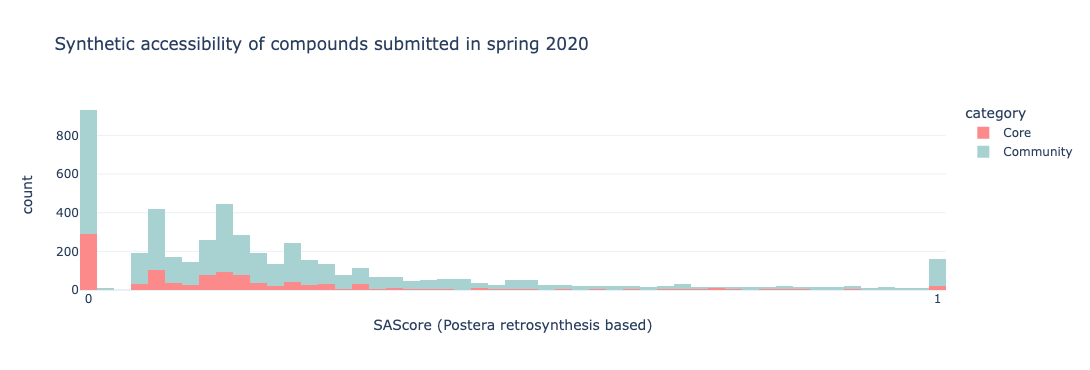

In [122]:
import plotly.express as px

fig = px.histogram(moonshot.loc[moonshot['quarter (submission)'] <= 2],
                   template="plotly_white",
                   color='category',
                   x='postera_SAScore',
                   title='Synthetic accessibility of compounds submitted in spring 2020',
                   color_discrete_map={'Core': '#FD8A8A', 'Community': '#A8D1D1', 'Prior SARS inhibitor': '#F1F7B5'}
                  )
fig.update_layout(xaxis=dict(title='SAScore (Postera retrosynthesis based)', dtick = 1),
                 )
fig.write_image("images/Q2-SA.jpg")
fig

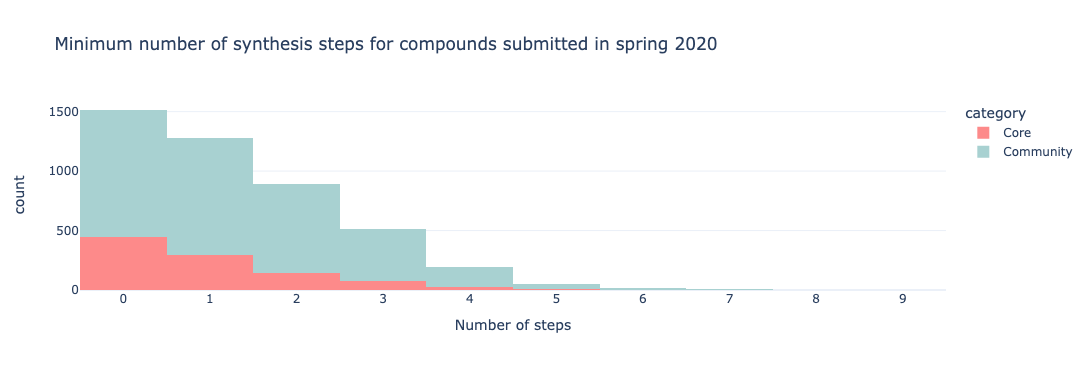

In [94]:
import plotly.express as px

fig = px.histogram(moonshot.loc[moonshot['quarter (submission)'] <= 2],
                   template="plotly_white",
                   color='category',
                   x='postera_minNumSteps',
                   title='Minimum number of synthesis steps for compounds submitted in spring 2020',
                   color_discrete_map={'Core': '#FD8A8A', 'Community': '#A8D1D1', 'Prior SARS inhibitor': '#F1F7B5'}
                  )
fig.update_layout(xaxis=dict(title='Number of steps', dtick = 1),
                 )

fig.write_image("images/Q2-steps.jpg")
fig

In [121]:
from scipy.stats import median_abs_deviation as mad

q = moonshot.loc[~moonshot.postera_SAScore.isna()]
sa_median = pd.pivot_table(q, index='category', values='postera_SAScore', aggfunc=np.median).postera_SAScore
sa_median.name = 'median'
sa_mad = pd.pivot_table(q, index='category', values='postera_SAScore', aggfunc=mad).postera_SAScore
sa_mad.name = 'MAD'
sa_count = pd.pivot_table(q, index='category', values='postera_SAScore', aggfunc=len).postera_SAScore
sa_count.name = 'count'

summary = pd.DataFrame([sa_median, sa_mad, sa_count]).transpose()
summary['faux-stderr'] = sa_mad / sa_count.apply(np.sqrt) / 0.67449
summary

,median,MAD,count,faux-stderr
category,,,,
Community,0.172683,0.104401,3919.0,0.002473
Core,0.137115,0.112301,1081.0,0.005064


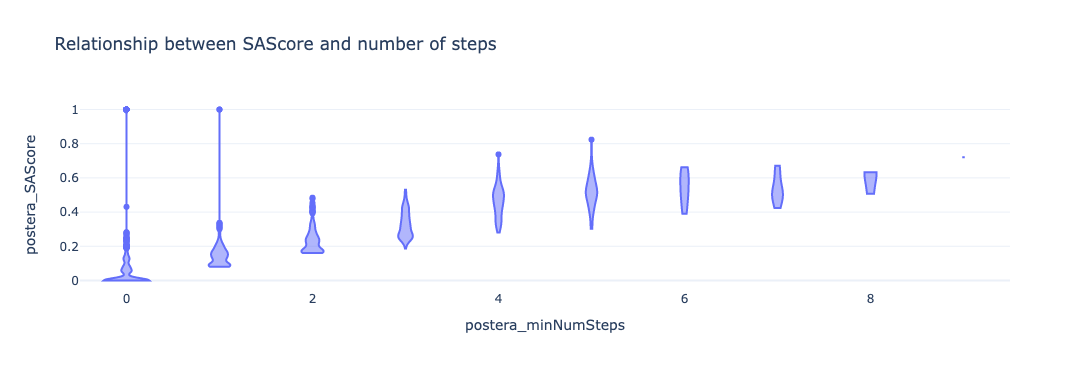

In [74]:
fig = px.violin(moonshot, x='postera_minNumSteps', y='postera_SAScore',
                 title='Relationship between SAScore and number of steps',
                 #color='category',
                 hover_data=['CID (canonical)', 'clean_creator', 'shipment_date'],
                 template="plotly_white")
fig.update_traces(spanmode = 'hard')
fig.write_image("images/SAScore-steps.jpg")
fig

In [88]:
from rdkit import Chem
from rdkit.Chem import Draw

q = moonshot.loc[(moonshot['quarter (submission)'] <= 2) & (moonshot.postera_minNumSteps > 4)]\
        .sort_values('postera_minNumSteps', ascending=False)
q['description'] = q['description'].str.replace('\'', ' ').str.replace('\"', ' ').str.replace('\t', ' ').str.replace('\n', ' ').str.replace('\r', ' ')
q['image'] = q['CID (canonical)'].apply(lambda cid: f'![{cid}](images/mols/{cid}@col.svg)')
for i, row in q.iterrows():
        d2d = Draw.MolDraw2DSVG(250, 200)
        d2d.drawOptions().useCDKAtomPalette()
        d2d.DrawMolecule(Chem.MolFromSmiles(row.SMILES))
        d2d.FinishDrawing()
        with open(f'images/mols/{i}@col.svg', 'w') as fh:
            fh.write(d2d.GetDrawingText())
# no 'clean_creator' to minimise shaming!
q[[ 'description', 'postera_SAScore','postera_minNumSteps']].to_markdown('Q2-SAScore_outliers.md')